In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 23.3 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import numpy as np
import optuna
import numpy as np
import pandas as pd
import warnings
import optuna

import matplotlib.pyplot as plt

from statsmodels.tsa.exponential_smoothing.ets import ETSModel



# **Ocupados Arima**

In [ ]:
pip install openpyxl

In [ ]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [ ]:
serie = data['Ocupados']
serie

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028


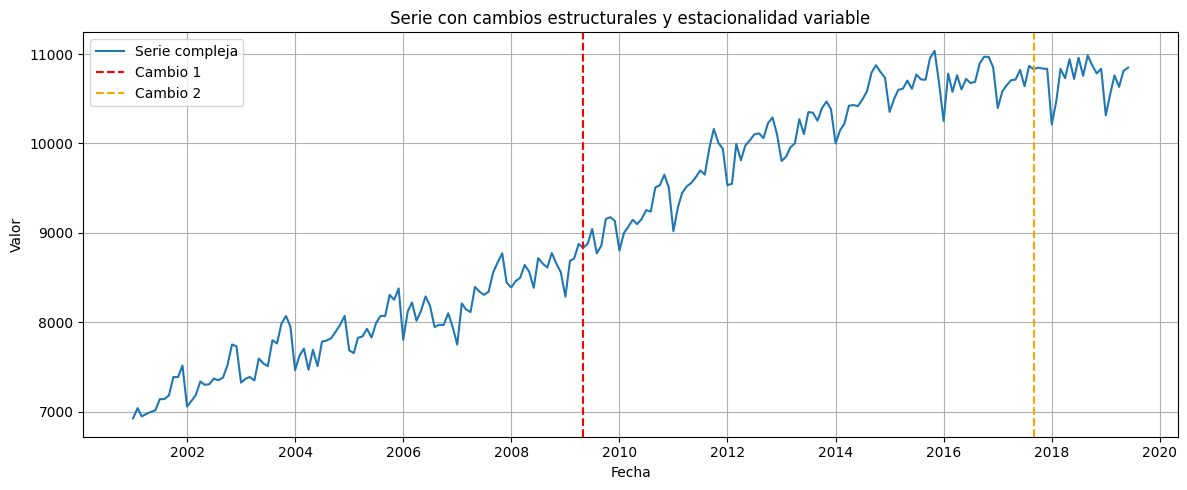

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(serie, label="Serie compleja")
plt.axvline(serie.index[100], color='red', linestyle='--', label="Cambio 1")
plt.axvline(serie.index[200], color='orange', linestyle='--', label="Cambio 2")
plt.title("Serie con cambios estructurales y estacionalidad variable")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **4. Función Entrenamiento**

In [ ]:
def evaluar_expanding_forecast(
      serie,
      order,
      window=12,
      step_size=1,
      horizon=1,
      metric='rmse',
      mobile_windows: bool = False,
    ):
    """
    Simula pronósticos autoregresivos en tiempo real con ventana expandida desde el inicio.

    Parámetros:
        serie     : serie temporal (pd.Series o array-like)
        order     : tupla ARIMA (p,d,q)
        window    : cantidad de pronósticos (desde el final hacia atrás)
        step_size : cada cuántos puntos se hace un pronóstico
        horizon   : cuántos pasos adelante predices en cada punto
        metric    : 'rmse' o 'mae'

    Retorna:
        Error promedio global (RMSE o MAE) entre todos los valores predichos vs observados.
    """

    # Asegurar tipo y limpiar NaN de la serie
    serie = pd.Series(serie).astype(float).dropna()

    n = len(serie)
    predichos = []
    observados = []

    # índices donde termina el conjunto de entrenamiento
    puntos_finales = list(range(n - window * step_size, n - horizon + 1, step_size))

    for end_train in puntos_finales:
        train = serie.iloc[end_train + window - n:end_train] if mobile_windows else serie.iloc[:end_train]
        test = serie.iloc[end_train:end_train + horizon]

        if len(test) < horizon:
            continue

        # Si el test ya tiene NaN, lo ignoramos
        if test.isna().any():
            continue

        try:
            model = ARIMA(
                train,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit()

            pred = model.forecast(steps=horizon)

        except Exception:
            # Si falla el ajuste o el forecast, pasamos a la siguiente ventana
            continue

        # Convertir a Series y filtrar NaN en predicciones
        pred = pd.Series(pred).astype(float)

        # Máscara conjunta para asegurar que ni observados ni predichos tengan NaN
        mask = (~pred.isna()) & (~test.isna())

        if mask.sum() == 0:
            continue

        predichos.extend(pred[mask].tolist())
        observados.extend(test[mask].tolist())

    if len(predichos) == 0:
        return np.inf

    predichos = np.array(predichos, dtype=float)
    observados = np.array(observados, dtype=float)

    mask_finite = (
        np.isfinite(predichos) &
        np.isfinite(observados)
    )

    if mask_finite.sum() == 0:
        return np.inf

    predichos = predichos[mask_finite]
    observados = observados[mask_finite]

    # Cálculo de la métrica
    if metric == 'rmse':
        return np.sqrt(mean_squared_error(observados, predichos))
    elif metric == 'mae':
        return np.mean(np.abs(observados - predichos))
    else:
        raise ValueError("Metric must be 'rmse' or 'mae'")


In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

**Validacion con ventana mobil**



In [ ]:
def objective_mobile(trial):

    p = trial.suggest_int("p", 1, 20)
    d = trial.suggest_int("d", 1, 2)
    q = trial.suggest_int("q", 1, 20)

    order = (p, d, q)
    return evaluar_expanding_forecast(serie, order, window=12, step_size=1, horizon=6, mobile_windows=True)


study_mobile = optuna.create_study(direction="minimize")
study_mobile.optimize(objective_mobile, n_trials=20 )


[I 2025-11-24 02:05:28,399] A new study created in memory with name: no-name-ce21e9c5-c1a7-45bb-a985-a7af6bd74c8c
[I 2025-11-24 02:06:03,812] Trial 0 finished with value: 103.09171145470023 and parameters: {'p': 16, 'd': 1, 'q': 16}. Best is trial 0 with value: 103.09171145470023.
[I 2025-11-24 02:06:49,117] Trial 1 finished with value: 152.4508323534661 and parameters: {'p': 20, 'd': 1, 'q': 8}. Best is trial 0 with value: 103.09171145470023.
[I 2025-11-24 02:07:04,137] Trial 2 finished with value: 140.66596873516636 and parameters: {'p': 15, 'd': 2, 'q': 1}. Best is trial 0 with value: 103.09171145470023.
[I 2025-11-24 02:07:42,167] Trial 3 finished with value: 126.38502190960322 and parameters: {'p': 6, 'd': 2, 'q': 18}. Best is trial 0 with value: 103.09171145470023.
[I 2025-11-24 02:08:04,062] Trial 4 finished with value: 125.75194351010607 and parameters: {'p': 19, 'd': 1, 'q': 2}. Best is trial 0 with value: 103.09171145470023.
[I 2025-11-24 02:08:37,086] Trial 5 finished with v

In [ ]:
fig_parallel = optuna.visualization.plot_parallel_coordinate(study_mobile)
fig_parallel

In [ ]:
print("Mejor ensayo (modelo) encontrado:")
trial_mobile = study_mobile.best_trial
print(f"  Valor (RMSE): {trial_mobile.value:.4f}")
print("  Hiperparámetros (p, d, q):")
for key, value in trial_mobile.params.items():
    print(f"    {key}: {value}")

Mejor ensayo (modelo) encontrado:
  Valor (RMSE): 103.0917
  Hiperparámetros (p, d, q):
    p: 16
    d: 1
    q: 16


**Validacion con ventana recursiva**


In [ ]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



Num GPUs Available:  1


In [ ]:
def objective_recursive(trial):
      p = trial.suggest_int("p", 1, 20)
      d = trial.suggest_int("d", 1, 2)
      q = trial.suggest_int("q", 1, 20)

      order = (p, d, q)
      return evaluar_expanding_forecast(serie, order, window=12, step_size=1, horizon=6, mobile_windows=False)

with tf.device('/device:GPU:0'):
  study_recursive = optuna.create_study(direction="minimize")
  study_recursive.optimize(objective_recursive, n_trials=20 )


[I 2025-11-24 02:19:51,323] A new study created in memory with name: no-name-e518a35b-73e2-4ff1-bb91-095d9bb7c9a4
[I 2025-11-24 02:20:14,469] Trial 0 finished with value: 158.0028201755545 and parameters: {'p': 12, 'd': 1, 'q': 11}. Best is trial 0 with value: 158.0028201755545.
[I 2025-11-24 02:20:19,260] Trial 1 finished with value: 304.77310344534175 and parameters: {'p': 8, 'd': 2, 'q': 1}. Best is trial 0 with value: 158.0028201755545.
[I 2025-11-24 02:20:33,285] Trial 2 finished with value: 175.78521791335578 and parameters: {'p': 9, 'd': 2, 'q': 6}. Best is trial 0 with value: 158.0028201755545.
[I 2025-11-24 02:21:07,244] Trial 3 finished with value: 135.26846644126948 and parameters: {'p': 9, 'd': 1, 'q': 18}. Best is trial 3 with value: 135.26846644126948.
[I 2025-11-24 02:21:49,108] Trial 4 finished with value: 1471.0516356233632 and parameters: {'p': 18, 'd': 2, 'q': 10}. Best is trial 3 with value: 135.26846644126948.
[I 2025-11-24 02:22:28,683] Trial 5 finished with value

In [ ]:
fig_parallel = optuna.visualization.plot_parallel_coordinate(study_recursive)
fig_parallel

In [ ]:
print("Mejor ensayo (modelo) encontrado:")
trial_recursive = study_recursive.best_trial
print(f"  Valor (RMSE): {trial_recursive.value:.4f}")
print("  Hiperparámetros (p, d, q):")
for key, value in trial_recursive.params.items():
    print(f"    {key}: {value}")

Mejor ensayo (modelo) encontrado:
  Valor (RMSE): 100.9798
  Hiperparámetros (p, d, q):
    p: 20
    d: 1
    q: 14


# **Resultado Arima**

## Ventama recursiva
1. Mejor ensayo (modelo) encontrado a 200 iteraciones:
  Valor (RMSE): 113.8049
  Hiperparámetros (p, d, q):
    * p: 10
    * d: 1
    * q: 10

2.

In [ ]:
# fig = optuna.visualization.plot_slice(study)
# fig

# **Ocupados HoltWinters**

In [ ]:
def evaluar_expanding_forecast_holt_winters(
      serie,
      error,
      trend,
      seasonal,
      aplha,
      beta,
      gama,
      window=12,
      step_size=1,
      horizon=1,
      metric='rmse',
      mobile_windows: bool = False,
    ):
    """
    Simula pronósticos autoregresivos en tiempo real con ventana expandida desde el inicio.

    Parámetros:
        serie     : serie temporal (pd.Series o array-like)
        order     : tupla ARIMA (p,d,q)
        window    : cantidad de pronósticos (desde el final hacia atrás)
        step_size : cada cuántos puntos se hace un pronóstico
        horizon   : cuántos pasos adelante predices en cada punto
        metric    : 'rmse' o 'mae'

    Retorna:
        Error promedio global (RMSE o MAE) entre todos los valores predichos vs observados.
    """

    # Asegurar tipo y limpiar NaN de la serie
    serie = pd.Series(serie).astype(float).dropna()

    n = len(serie)
    predichos = []
    observados = []

    # índices donde termina el conjunto de entrenamiento
    puntos_finales = list(range(n - window * step_size, n - horizon + 1, step_size))

    for end_train in puntos_finales:
        train = serie.iloc[end_train + window - n:end_train] if mobile_windows else serie.iloc[:end_train]
        test = serie.iloc[end_train:end_train + horizon]

        if len(test) < horizon:
            continue

        # Si el test ya tiene NaN, lo ignoramos
        if test.isna().any():
            continue

        try:
            model = ETSModel(
                endog=train,
                error=error,
                trend=trend,
                seasonal=seasonal,
                # seasonal_periods=1
            )

            model_fit = model.fit_constrained({
                'smoothing_level': aplha,
                'smoothing_trend': beta,
                'smoothing_seasonal': gama
            })

            pred = model_fit.forecast(steps=horizon)

        except Exception:
            # Si falla el ajuste o el forecast, pasamos a la siguiente ventana
            continue

        # Convertir a Series y filtrar NaN en predicciones
        pred = pd.Series(pred).astype(float)

        # Máscara conjunta para asegurar que ni observados ni predichos tengan NaN
        mask = (~pred.isna()) & (~test.isna())

        if mask.sum() == 0:
            continue

        predichos.extend(pred[mask].tolist())
        observados.extend(test[mask].tolist())

    if len(predichos) == 0:
        return np.inf

    predichos = np.array(predichos, dtype=float)
    observados = np.array(observados, dtype=float)

    mask_finite = (
        np.isfinite(predichos) &
        np.isfinite(observados)
    )

    if mask_finite.sum() == 0:
        return np.inf

    predichos = predichos[mask_finite]
    observados = observados[mask_finite]

    # Cálculo de la métrica
    if metric == 'rmse':
        return np.sqrt(mean_squared_error(observados, predichos))
    elif metric == 'mae':
        return np.mean(np.abs(observados - predichos))
    else:
        raise ValueError("Metric must be 'rmse' or 'mae'")


In [ ]:
def objective_holt_winters_mobile_windows(trial):

    error = trial.suggest_categorical("error", ['add', 'mul'])
    trend = trial.suggest_categorical("trend", ['add', 'mul', None])
    seasonal = trial.suggest_categorical("seasonal", ['add', 'mul', None])

    aplha = trial.suggest_float("aplha", 0.0, 1.0)
    beta = trial.suggest_float("beta", 0.0, 1.0)
    gama = trial.suggest_float("gamma", 0.0, 1.0)

    return evaluar_expanding_forecast_holt_winters(
        serie=serie,
        error=error,
        trend=trend,
        seasonal=seasonal,
        aplha=aplha,
        beta=beta,
        gama=gama,
        window=12,
        step_size=1,
        horizon=6,
        mobile_windows=True,
        metric='rmse'
    )

study_holt_winters_mobile_windows = optuna.create_study(direction="minimize")
study_holt_winters_mobile_windows.optimize(objective_holt_winters_mobile_windows, n_trials=500, n_jobs=-1)


[I 2025-11-24 02:42:08,200] A new study created in memory with name: no-name-9ba6684d-1587-418d-8d18-3a50850eabb9
[I 2025-11-24 02:42:08,240] Trial 0 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'seasonal': None, 'aplha': 0.4988878510261955, 'beta': 0.7381196212798328, 'gamma': 0.5156800600091361}. Best is trial 0 with value: inf.
[I 2025-11-24 02:42:08,266] Trial 1 finished with value: inf and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add', 'aplha': 0.5400326018548918, 'beta': 0.10426120534831707, 'gamma': 0.909435941990738}. Best is trial 0 with value: inf.
[I 2025-11-24 02:42:08,283] Trial 2 finished with value: inf and parameters: {'error': 'add', 'trend': 'add', 'seasonal': None, 'aplha': 0.001826149640556718, 'beta': 0.7238873190139062, 'gamma': 0.041392368396245605}. Best is trial 0 with value: inf.
[I 2025-11-24 02:42:08,333] Trial 3 finished with value: inf and parameters: {'error': 'mul', 'trend': None, 'seasonal': 'mul', 'aplha': 0

In [ ]:
fig_parallel_mobile_windows = optuna.visualization.plot_parallel_coordinate(study_holt_winters_mobile_windows)
fig_parallel_mobile_windows

[W 2025-11-24 02:48:36,763] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 02:48:36,765] Trial 1 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 02:48:36,766] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 02:48:36,767] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 02:48:36,767] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 02:48:36,768] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 02:48:36,769] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 02:48:36,770] Trial 9 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 02:48:36,771] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 02:48:36,772] Trial 29

In [ ]:
print("Mejor ensayo (modelo) encontrado:")
trial_holt_winters_mobile_windows = study_holt_winters_mobile_windows.best_trial
print(f"  Valor (RMSE): {trial_holt_winters_mobile_windows.value:.4f}")
print("  Hiperparámetros:")
for key, value in trial_holt_winters_mobile_windows.params.items():
    print(f"    {key}: {value}")

Mejor ensayo (modelo) encontrado:
  Valor (RMSE): 100.2114
  Hiperparámetros:
    error: mul
    trend: add
    seasonal: add
    aplha: 0.0663634761862128
    beta: 0.01769964991661972
    gamma: 0.21325520956249489


In [ ]:
def objective_holt_winters_recursive_windows(trial):

    error = trial.suggest_categorical("error", ['add', 'mul'])
    trend = trial.suggest_categorical("trend", ['add', 'mul', None])
    seasonal = trial.suggest_categorical("seasonal", ['add', 'mul', None])

    aplha = trial.suggest_float("aplha", 0.0, 0.99)
    beta = trial.suggest_float("beta", 0.0, 0.99)
    gama = trial.suggest_float("gamma", 0.0, 0.99)

    return evaluar_expanding_forecast_holt_winters(
        serie=serie,
        error=error,
        trend=trend,
        seasonal=seasonal,
        aplha=aplha,
        beta=beta,
        gama=gama,
        window=12,
        step_size=1,
        horizon=6,
        mobile_windows=False,
        metric='rmse'
    )

study_holt_winters_recursive_windows = optuna.create_study(direction="minimize")
study_holt_winters_recursive_windows.optimize(objective_holt_winters_recursive_windows, n_trials=500, n_jobs=-1)

[I 2025-11-24 03:20:09,071] A new study created in memory with name: no-name-9ac8d7eb-49e3-408e-bec7-0de08152f373
[I 2025-11-24 03:20:09,127] Trial 1 finished with value: inf and parameters: {'error': 'add', 'trend': None, 'seasonal': 'mul', 'aplha': 0.12094222066744853, 'beta': 0.9201831995330252, 'gamma': 0.900926027599182}. Best is trial 1 with value: inf.
[I 2025-11-24 03:20:09,130] Trial 0 finished with value: inf and parameters: {'error': 'add', 'trend': 'mul', 'seasonal': None, 'aplha': 0.15084144861070836, 'beta': 0.04842343395352042, 'gamma': 0.11226697390315128}. Best is trial 1 with value: inf.
[I 2025-11-24 03:20:09,194] Trial 3 finished with value: inf and parameters: {'error': 'mul', 'trend': None, 'seasonal': None, 'aplha': 0.9436404573381852, 'beta': 0.6904182727457641, 'gamma': 0.3067083215063141}. Best is trial 1 with value: inf.
[I 2025-11-24 03:20:10,800] Trial 4 finished with value: 140.37464101751357 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': 'ad

15 pto

In [ ]:
fig_parallel_recursive_windows = optuna.visualization.plot_parallel_coordinate(study_holt_winters_recursive_windows)
fig_parallel_recursive_windows

[W 2025-11-24 03:19:13,035] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:19:13,037] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:19:13,037] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:19:13,038] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:19:13,038] Trial 7 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:19:13,039] Trial 20 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:19:13,039] Trial 29 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:19:13,041] Trial 31 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:19:13,041] Trial 37 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:19:13,042] Trial

In [ ]:
print("Mejor ensayo (modelo) encontrado:")
trial_holt_winters_recursive_windows = study_holt_winters_recursive_windows.best_trial
print(f"  Valor (RMSE): {trial_holt_winters_recursive_windows.value:.4f}")
print("  Hiperparámetros:")
for key, value in trial_holt_winters_recursive_windows.params.items():
    print(f"    {key}: {value}")

Mejor ensayo (modelo) encontrado:
  Valor (RMSE): 100.1681
  Hiperparámetros:
    error: mul
    trend: add
    seasonal: add
    aplha: 0.014845607154005281
    beta: 0.0761380519733525
    gamma: 0.495098349009105


12 pto

In [ ]:
fig_parallel_recursive_windows = optuna.visualization.plot_parallel_coordinate(study_holt_winters_recursive_windows)
fig_parallel_recursive_windows

[W 2025-11-24 03:27:17,726] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:27:17,727] Trial 1 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:27:17,729] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:27:17,730] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:27:17,731] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:27:17,732] Trial 7 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:27:17,732] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:27:17,733] Trial 20 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:27:17,734] Trial 29 is omitted in visualization because its objective value is inf or nan.
[W 2025-11-24 03:27:17,734] Trial 

In [ ]:
print("Mejor ensayo (modelo) encontrado:")
trial_holt_winters_recursive_windows = study_holt_winters_recursive_windows.best_trial
print(f"  Valor (RMSE): {trial_holt_winters_recursive_windows.value:.4f}")
print("  Hiperparámetros:")
for key, value in trial_holt_winters_recursive_windows.params.items():
    print(f"    {key}: {value}")

Mejor ensayo (modelo) encontrado:
  Valor (RMSE): 80.9687
  Hiperparámetros:
    error: add
    trend: mul
    seasonal: mul
    aplha: 0.023598705038131877
    beta: 0.02797782513841357
    gamma: 0.6271805991993634


Modelo completo

In [ ]:
end_model = ETSModel(
    endog=serie,
    error='add',
    trend='mul',
    seasonal='mul',
)

In [ ]:
end_model_fit = end_model.fit_constrained({
    'smoothing_level': 0.023598705038131877,
    'smoothing_trend': 0.02797782513841357,
    'smoothing_seasonal': 0.6271805991993634
})

In [ ]:
print(end_model_fit.alpha, end_model_fit.beta, end_model_fit.gamma)

0.023598705038131877 0.02797782513841357 0.6271805991993634


In [ ]:
feature_end_model = end_model_fit.forecast(6)

ci = end_model_fit.get_prediction(
    start= feature_end_model.index[0],
    end= feature_end_model.index[-1]
)

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean

preds_hw = pd.concat([limits, conf_forecast], axis=1)
preds_hw.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds_hw

,Point_forecast,lower_95,upper_95
2019-07-01,10867.543928,10436.812781,11349.659291
2019-08-01,10785.120116,10369.050704,11247.140604
2019-09-01,10935.361993,10475.163459,11382.756993
2019-10-01,10877.553612,10416.393803,11324.311771
2019-11-01,10815.850503,10307.301710,11289.295568
2019-12-01,10825.082332,10357.666250,11316.444224


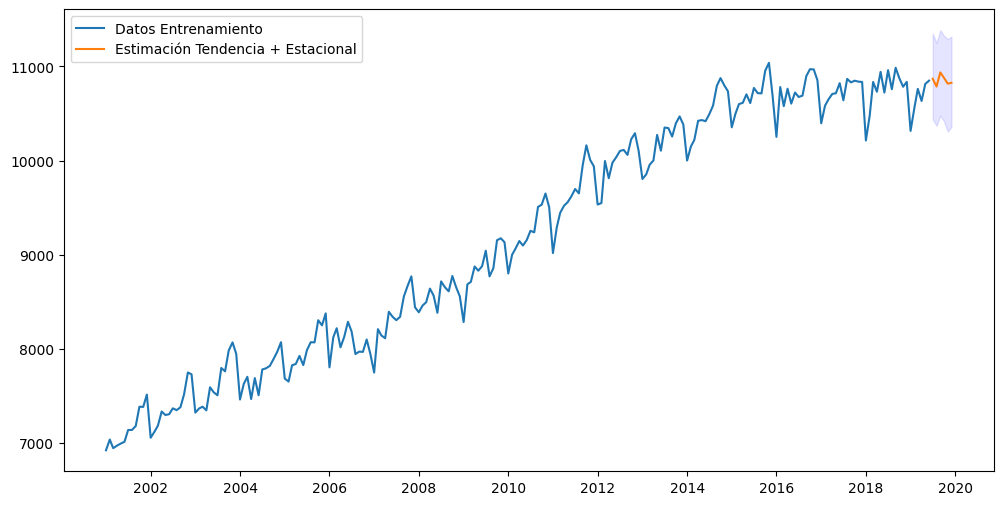

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(serie,label="Datos Entrenamiento")
plt.plot(preds_hw['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds_hw.index,preds_hw['lower_95'], preds_hw['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()